In [25]:
import pandas as pd
import boto3
import os
from io import StringIO
pd.set_option("display.max_columns", 50)
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
aws_acess_key_id = os.getenv("AWS_ACCESS_KEY")
aws_secret_key = os.getenv("AWS_SECRET_KEY")

In [3]:
def read_csv_from_s3(bucket: str, path: str, filename:str)->pd.DataFrame:
    """ Dwonloads a csv file from an S3 bucket.
    Parameters
    ---------
    bucket: str
    The bucket is where the files at.
    path: str
    The folders to the file.
    filename: str
    Name of the file.
    Retuns: 
    ------
    pd.DataFrame
    A DataFrame of the downloaded file.
    """
    s3 = boto3.client("s3", aws_access_key_id = aws_acess_key_id, aws_secret_access_key =aws_secret_key)
    full_path = f"{path}{filename}"
    
    object = s3.get_object(Bucket = bucket, Key = full_path)
    object = object["Body"].read().decode("utf-8")
    output_df = pd.read_csv(StringIO(object))
    return output_df

In [4]:
s3 = boto3.client("s3", aws_access_key_id = aws_acess_key_id, aws_secret_access_key =aws_secret_key)
bucket = "cubix-chichago-taxi-ta"

community_areas_path = "transformed_data/community_areas/"
companty_path = "transformed_data/company/"
date_path = "transformed_data/date/"
payment_type_path = "transformed_data/payment_type/"
taxi_trips_path = "transformed_data/taxi_trips/"
weather_path = "transformed_data/weather/"

In [5]:
community_areas = read_csv_from_s3(bucket=bucket, path=community_areas_path, filename = "community_areas_master.csv")
company = read_csv_from_s3(bucket=bucket, path=companty_path, filename = "company_master_.csv")
date = read_csv_from_s3(bucket=bucket, path=date_path, filename = "date_dimension.csv")
payment_type = read_csv_from_s3(bucket=bucket, path=payment_type_path, filename = "payment_type_master.csv")

In [6]:
trips_list = []
weather_list = []

In [7]:

for file in s3.list_objects(Bucket = bucket, Prefix = taxi_trips_path )["Contents"]:
    taxi_trip_key = file["Key"]
                
    if taxi_trip_key.split("/")[-1].strip() !="":
        if taxi_trip_key.split(".")[1] == "csv":
            filename = taxi_trip_key.split("/")[-1]
            trip = read_csv_from_s3(bucket, taxi_trips_path, filename)
            trips_list.append(trip)
            print(f"{filename} has been added.")       
                        
     

taxi_2024-03-15.csv has been added.
taxi_2024-03-19.csv has been added.
taxi_2024-03-20.csv has been added.
taxi_2024-03-21.csv has been added.
taxi_2024-03-22.csv has been added.
taxi_2024-03-23.csv has been added.
taxi_2024-03-24.csv has been added.
taxi_2024-03-25.csv has been added.
taxi_2024-03-26.csv has been added.
taxi_2024-03-27.csv has been added.


In [8]:
trips = pd.concat(trips_list, ignore_index=True)

In [9]:
trips.shape

(191256, 20)

In [10]:
#WEATHER DATA TRANSFORMATION AND LOADING
for file in s3.list_objects(Bucket = bucket, Prefix = weather_path )["Contents"]:
    weather_key = file["Key"]
        
    if weather_key.split("/")[-1].strip() !="":
        if weather_key.split(".")[1] == "csv":
            filename = weather_key.split("/")[-1]
            weather_daily = read_csv_from_s3(bucket, weather_path, filename)
            weather_list.append(weather_daily)
            print(f"{filename} has been added.")      


    

weather_2024-03-19.csv has been added.
weather_2024-03-20.csv has been added.
weather_2024-03-21.csv has been added.
weather_2024-03-22.csv has been added.
weather_2024-03-23.csv has been added.
weather_2024-03-24.csv has been added.
weather_2024-03-25.csv has been added.
weather_2024-03-26.csv has been added.
weather_2024-03-27.csv has been added.


In [11]:
weather = pd.concat(weather_list, ignore_index=True)

In [12]:
weather.head()

,datetime,temperature,windspeed,rain,precipitation
0,2024-03-19 00:00:00,-0.1,15.5,0.0,0.0
1,2024-03-19 01:00:00,-0.2,12.0,0.0,0.0
2,2024-03-19 02:00:00,-0.4,10.4,0.0,0.0
3,2024-03-19 03:00:00,-0.4,13.9,0.0,0.0
4,2024-03-19 04:00:00,-0.5,14.9,0.0,0.0


#### joining the data together

In [13]:
trips_full = pd.merge (trips,weather, left_on = "datetime_for_weather", right_on = "datetime", how= "inner")
trips_full = trips_full.drop(columns=["datetime"])

In [14]:
trips_full = pd.merge(trips_full, company, left_on= "company_id", right_on="company_id", how = "inner")
trips_full = trips_full.drop(columns=["company_id"])

In [15]:
trips_full = pd.merge(trips_full, payment_type, left_on= "payment_type_id", right_on="payment_type_id", how = "inner")
trips_full = trips_full.drop(columns=["payment_type_id"])

In [16]:
trips_full = pd.merge(trips_full, community_areas, left_on= "pickup_community_area_id", right_on="area_code", how = "inner")
trips_full = trips_full.drop(columns=["pickup_community_area_id", "area_code"])
trips_full.rename(columns={"community_name":"pickup_community_area_name"}, inplace=True)


In [17]:
trips_full = pd.merge(trips_full, community_areas, left_on= "dropoff_community_area_id", right_on="area_code", how = "inner")
trips_full = trips_full.drop(columns=["dropoff_community_area_id", "area_code"])
trips_full.rename(columns={"community_name":"dropoff_community_area_name"}, inplace=True)


In [18]:
date ['date'] = pd.to_datetime(date['date'])
trips_full['trip_start_timestamp'] = pd.to_datetime(trips_full["trip_start_timestamp"])

In [19]:
trips_full['trip_start_date'] = trips_full['trip_start_timestamp'].dt.date # date conversion
trips_full['trip_start_date'] = pd.to_datetime(trips_full["trip_start_date"])

In [ ]:
trips_full.head()
#2024-03-19T23:45:00.000
#2024-01-01


In [21]:
trips_full = pd.merge(trips_full, date, left_on= "trip_start_date", right_on="date", how = "inner")
trips_full = trips_full.drop(columns = ["date"])

In [39]:
trips_full.head(100)


,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,datetime_for_weather,temperature,windspeed,rain,precipitation,company,payment_type,pickup_community_area_name,dropoff_community_area_name,trip_start_date,year,month,day,dayofweek,day_of_week,isweekend
0,83bb042d6e58d0707afcbc8ba908d97f8515d8d1,64fef3c62cbbc9dd8c00e7e1cf6d29ea73d9ebdd758d4f...,2024-03-19 23:45:00,2024-03-20T00:00:00.000,764,1.83,9.25,0.00,0.0,0.0,9.25,41.899602,-87.633308,41.899602,-87.633308,2024-03-19 23:00:00,12.8,23.0,0.0,0.0,5 Star Taxi,Prcard,Near North Side,Near North Side,2024-03-19,2024,3,19,2,2,False
1,8dc0fd176586c4222014a953faf2026372b1b772,ca02e7fc918d4841d7888e2b6acb048652209bb7adf512...,2024-03-19 23:45:00,2024-03-20T00:15:00.000,1380,17.30,42.50,9.70,0.0,5.5,57.70,41.980264,-87.913625,41.878866,-87.625192,2024-03-19 23:00:00,12.8,23.0,0.0,0.0,Taxi Affiliation Services,Credit Card,O'Hare,Loop,2024-03-19,2024,3,19,2,2,False
2,9018fc16da51c60ff25d15a77c024c544bafe72b,2c2846e06a06b51bf72e041bce82b95d5471941476ff25...,2024-03-19 23:45:00,2024-03-20T00:00:00.000,399,0.75,9.00,1.67,0.0,0.0,10.67,41.899602,-87.633308,41.878866,-87.625192,2024-03-19 23:00:00,12.8,23.0,0.0,0.0,Taxicab Insurance Agency Llc,Mobile,Near North Side,Loop,2024-03-19,2024,3,19,2,2,False
3,92d05304c4b2a60c5e042096a3ad474f6c94fec5,3b95cedc13d4a99243e1974616a6a25267c25878336faa...,2024-03-19 23:45:00,2024-03-20T00:15:00.000,1680,0.90,36.50,5.00,0.0,5.0,46.50,41.792592,-87.769615,41.947792,-87.683835,2024-03-19 23:00:00,12.8,23.0,0.0,0.0,Taxi Affiliation Services,Credit Card,Garfield Ridge,North Center,2024-03-19,2024,3,19,2,2,False
4,96af235e2e148543fc786569515d98ce38bc3e28,c7a8a53874bbcdb11e70a488485e8bdd0bb8cc0de8f5d9...,2024-03-19 23:45:00,2024-03-20T00:00:00.000,730,11.16,28.50,0.00,0.0,0.0,28.50,41.890609,-87.756047,41.922761,-87.699155,2024-03-19 23:00:00,12.8,23.0,0.0,0.0,Flash Cab,Prcard,Austin,Logan Square,2024-03-19,2024,3,19,2,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,179993bf58db81b53cdb1a7b1f192a9fdc416420,fca0a8e9246c5f754725d46da0661e884e50559c957ab7...,2024-03-19 23:30:00,2024-03-19T23:45:00.000,1167,9.57,26.00,6.10,0.0,4.0,36.60,41.785999,-87.750934,41.859350,-87.617358,2024-03-19 23:00:00,12.8,23.0,0.0,0.0,Taxicab Insurance Agency Llc,Credit Card,Garfield Ridge,Near South Side,2024-03-19,2024,3,19,2,2,False
96,1c08b4c865ff9588c1caf420d6f5f3162b16c6b6,617a9ea2929aa34568d879ef9400c1be77f2f96388cbec...,2024-03-19 23:30:00,2024-03-20T00:00:00.000,1338,17.01,42.50,9.40,0.0,4.0,56.40,41.980264,-87.913625,41.899602,-87.633308,2024-03-19 23:00:00,12.8,23.0,0.0,0.0,Taxicab Insurance Agency Llc,Credit Card,O'Hare,Near North Side,2024-03-19,2024,3,19,2,2,False
97,1dc59704d1d87a30df43370ffd2aac7a70f3bae6,7cb607b940a690e65b20dec20182d2646d3306f725130c...,2024-03-19 23:30:00,2024-03-20T00:00:00.000,1740,17.80,44.00,10.00,0.0,5.5,60.00,41.980264,-87.913625,41.899602,-87.633308,2024-03-19 23:00:00,12.8,23.0,0.0,0.0,Globe Taxi,Credit Card,O'Hare,Near North Side,2024-03-19,2024,3,19,2,2,False
98,25ea1ebd5d823a3045b872aa5eca9c288798f841,f0d6376865e19a2dae04d7d5401649247eb526372356ac...,2024-03-19 23:30:00,2024-03-19T23:30:00.000,5,0.00,24.00,0.00,0.0,0.0,24.00,41.878866,-87.625192,41.878866,-87.625192,2024-03-19 23:00:00,12.8,23.0,0.0,0.0,Taxicab Insurance Agency Llc,Cash,Loop,Loop,2024-03-19,2024,3,19,2,2,False


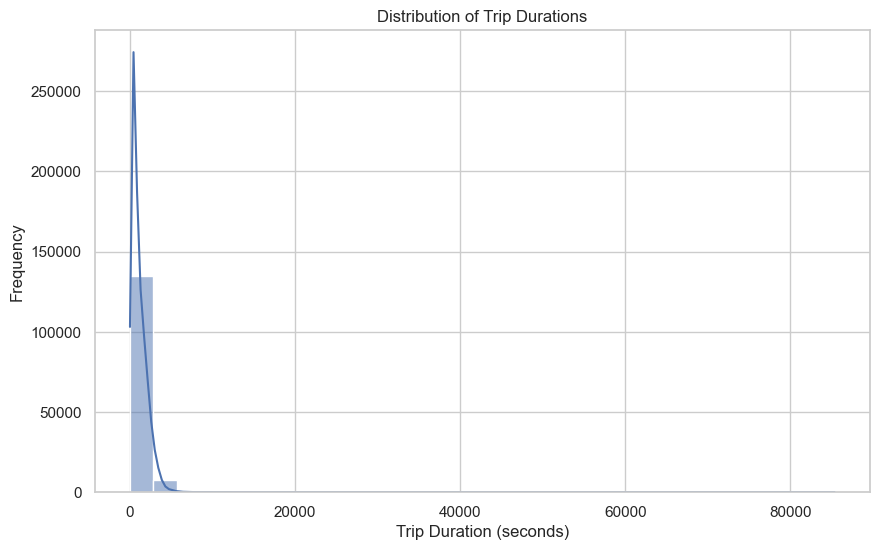

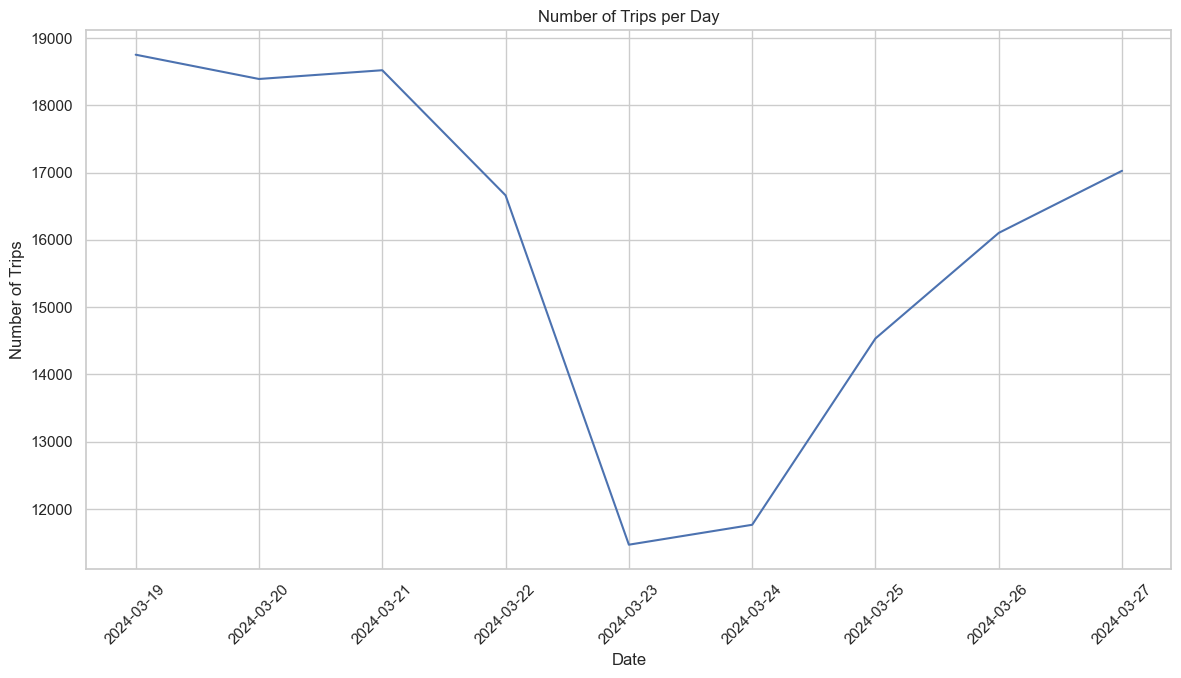

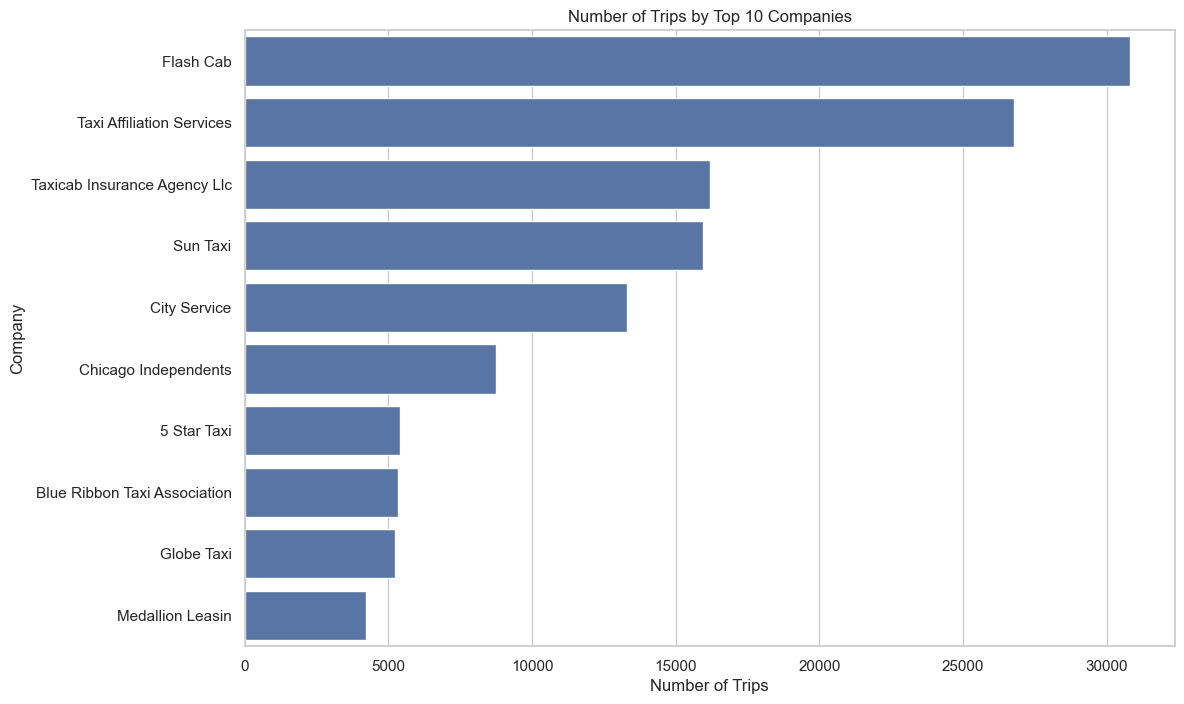

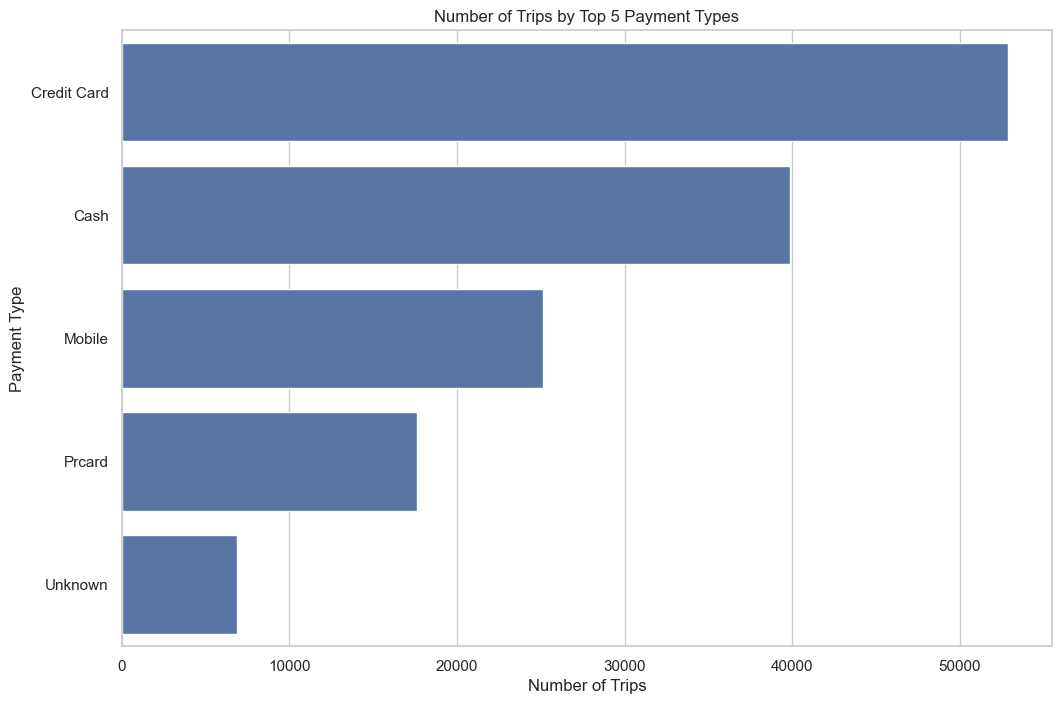

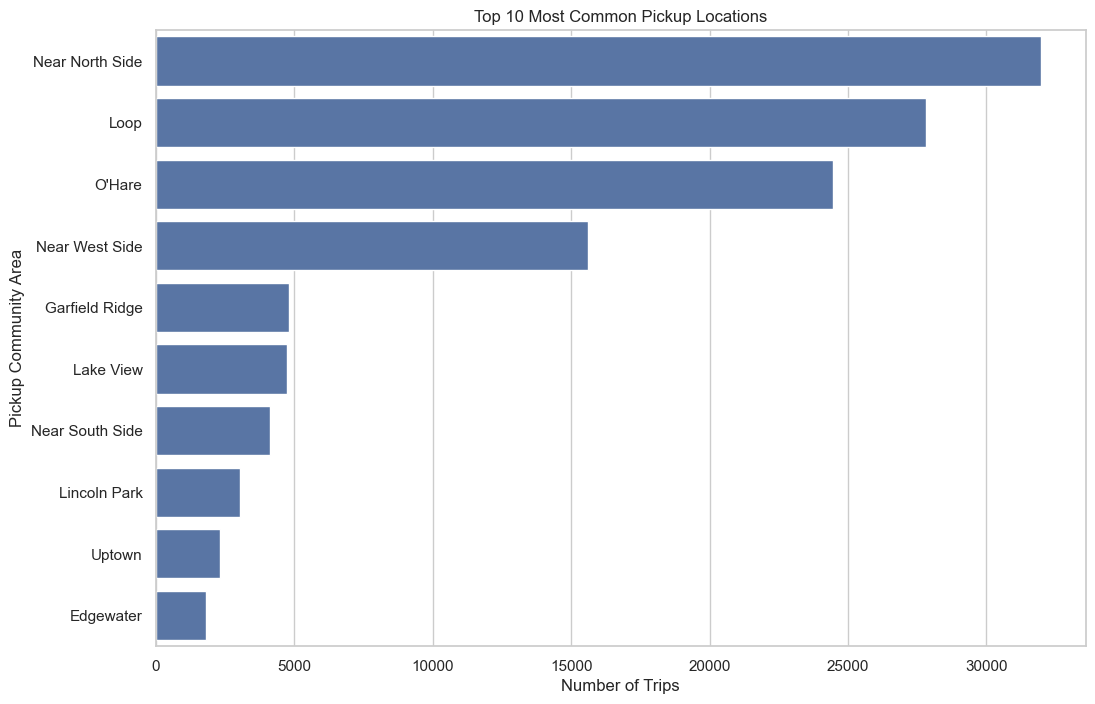

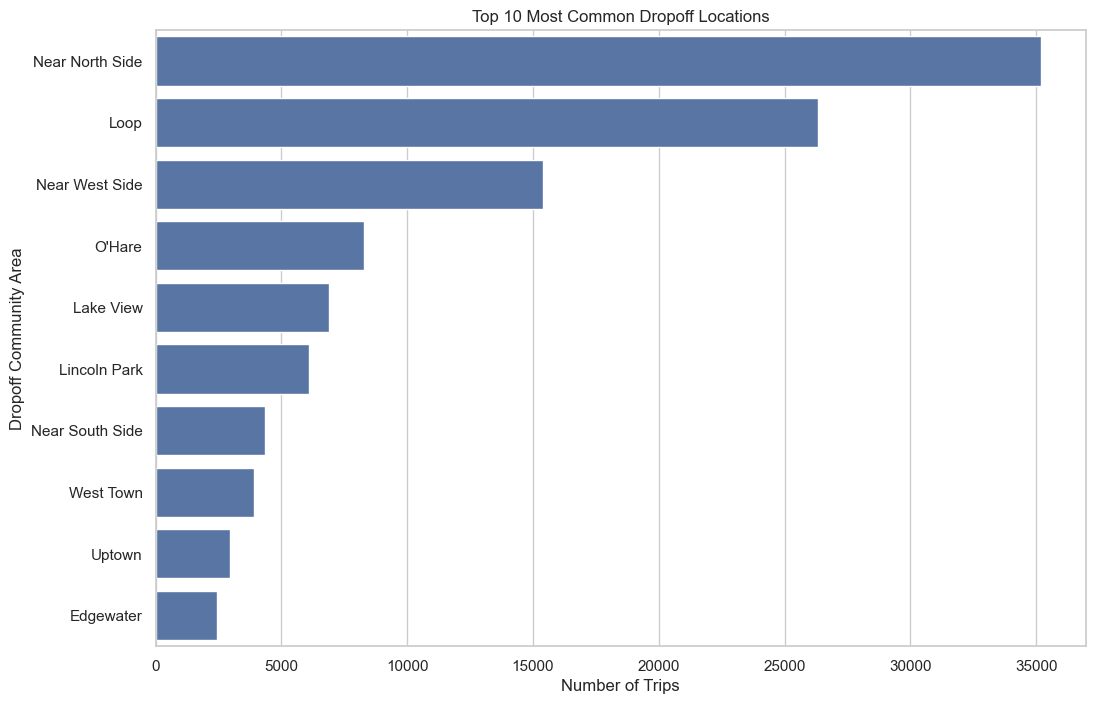

C:\Users\Ati\AppData\Local\Temp\ipykernel_24352\1078738839.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sizes = [weekend_weekday_counts[0], weekend_weekday_counts[1]]


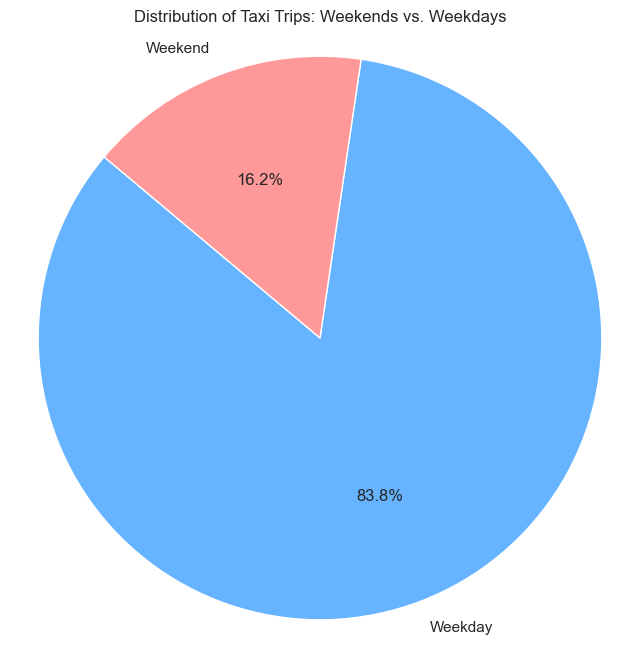

In [42]:


# Set the style of the visualizations
sns.set(style="whitegrid")

# Example 1: Distribution of Trip Durations
plt.figure(figsize=(10, 6))
sns.histplot(trips_full['trip_seconds'], bins=30, kde=True)
plt.title('Distribution of Trip Durations')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

# Example 2: Number of Trips per Day
trips_per_day = trips_full.groupby('trip_start_date').size().reset_index(name='num_trips')
plt.figure(figsize=(14, 7))
sns.lineplot(data=trips_per_day, x='trip_start_date', y='num_trips')
plt.title('Number of Trips per Day')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.show()

top_10_companies = trips_full['company'].value_counts().nlargest(10).index

# Filter the dataset to include only the top 10 companies
top_10_trips = trips_full[trips_full['company'].isin(top_10_companies)]

plt.figure(figsize=(12, 8))
sns.countplot(data=top_10_trips, y='company', order=top_10_trips['company'].value_counts().index)
plt.title('Number of Trips by Top 10 Companies')
plt.xlabel('Number of Trips')
plt.ylabel('Company')
plt.show()

top_5_payment_types = trips_full['payment_type'].value_counts().nlargest(5).index

# Filter the dataset to include only the top 5 payment types
top_5_trips = trips_full[trips_full['payment_type'].isin(top_5_payment_types)]

plt.figure(figsize=(12, 8))
sns.countplot(data=top_5_trips, y='payment_type', order=top_5_trips['payment_type'].value_counts().index)
plt.title('Number of Trips by Top 5 Payment Types')
plt.xlabel('Number of Trips')
plt.ylabel('Payment Type')
plt.show()

# Set the style of the visualizations
sns.set(style="whitegrid")

# Example: Most Common Pickup Locations
plt.figure(figsize=(12, 8))
top_10_pickup_areas = trips_full['pickup_community_area_name'].value_counts().nlargest(10).index
sns.countplot(data=trips_full[trips_full['pickup_community_area_name'].isin(top_10_pickup_areas)], 
              y='pickup_community_area_name', 
              order=top_10_pickup_areas)
plt.title('Top 10 Most Common Pickup Locations')
plt.xlabel('Number of Trips')
plt.ylabel('Pickup Community Area')
plt.show()

# Example: Most Common Dropoff Locations
plt.figure(figsize=(12, 8))
top_10_dropoff_areas = trips_full['dropoff_community_area_name'].value_counts().nlargest(10).index
sns.countplot(data=trips_full[trips_full['dropoff_community_area_name'].isin(top_10_dropoff_areas)], 
              y='dropoff_community_area_name', 
              order=top_10_dropoff_areas)
plt.title('Top 10 Most Common Dropoff Locations')
plt.xlabel('Number of Trips')
plt.ylabel('Dropoff Community Area')
plt.show()


# Count the number of trips for weekends and weekdays
weekend_weekday_counts = trips_full['isweekend'].value_counts()

# Define labels and sizes for the pie chart
labels = ['Weekday', 'Weekend']
sizes = [weekend_weekday_counts[0], weekend_weekday_counts[1]]

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#66b3ff', '#ff9999'])
plt.title('Distribution of Taxi Trips: Weekends vs. Weekdays')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()



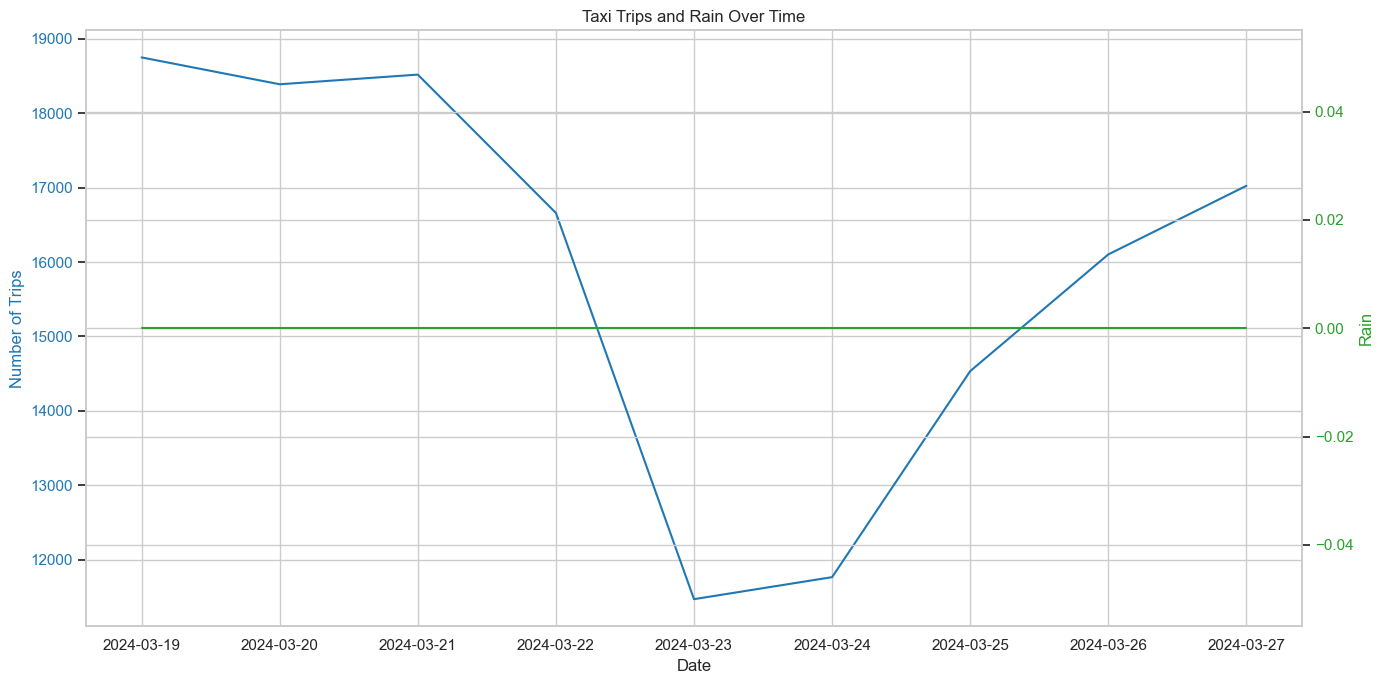

In [40]:
# Convert trip_start_timestamp to datetime if not already done
trips_full['trip_start_timestamp'] = pd.to_datetime(trips_full['trip_start_timestamp'])

# Aggregate the data to get the count of taxi trips per day
trips_per_day = trips_full.resample('D', on='trip_start_timestamp').size().reset_index(name='num_trips')

# Ensure the datetime column in weather data is in datetime format
weather['datetime'] = pd.to_datetime(weather['datetime'])

# Merge the aggregated data with the weather data to get rain 
rain_trips_data = pd.merge(trips_per_day, weather[['datetime', 'rain']], 
                           left_on='trip_start_timestamp', right_on='datetime', how='inner')

# Plot the rain  and taxi trip counts
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotting the number of trips
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Trips', color='tab:blue')
ax1.plot(rain_trips_data['trip_start_timestamp'], rain_trips_data['num_trips'], color='tab:blue', label='Number of Trips')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis to plot the rain 
ax2 = ax1.twinx()
ax2.set_ylabel('Rain', color='tab:green')
ax2.plot(rain_trips_data['trip_start_timestamp'], rain_trips_data['rain'], color='tab:green', label='Rain')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Title and show the plot
plt.title('Taxi Trips and Rain Over Time')
fig.tight_layout()
plt.show()

C:\Users\Ati\AppData\Local\Temp\ipykernel_24352\4055445573.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=trip_total_per_company, x='trip_total', y='company', palette='viridis')


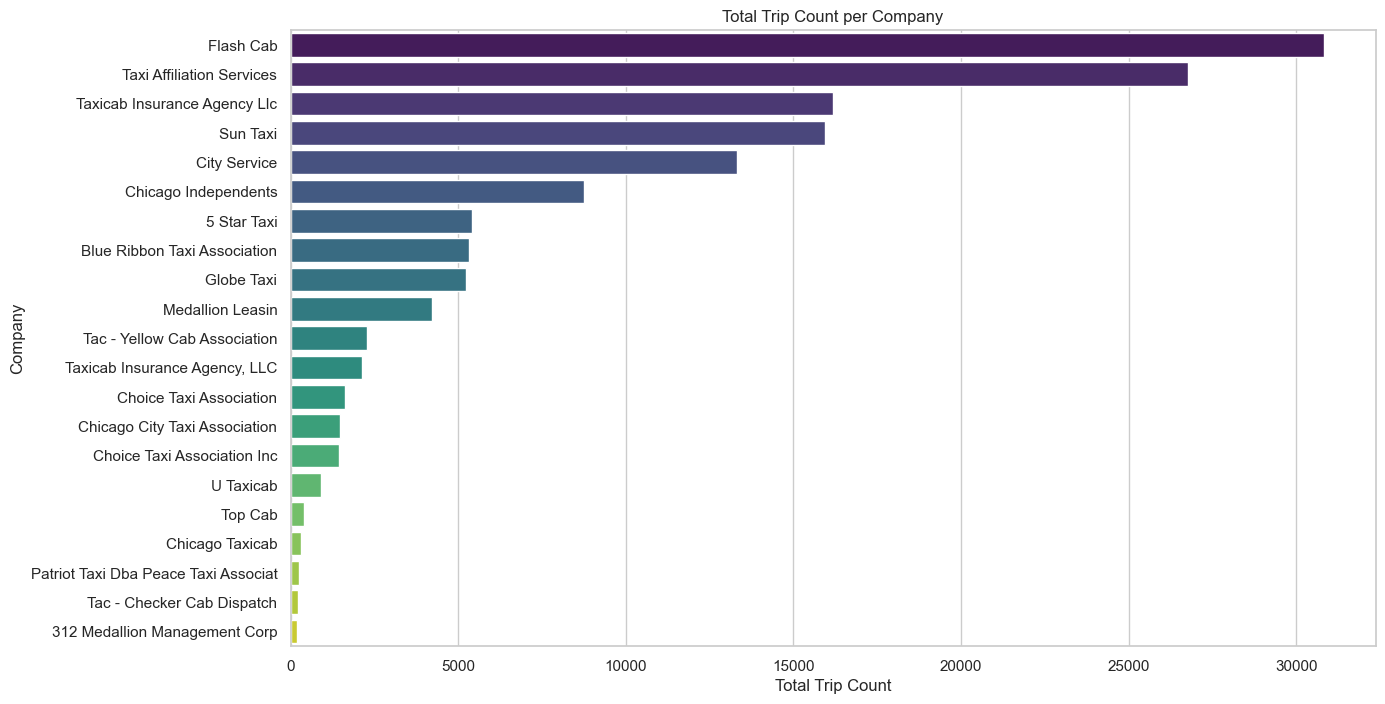

In [41]:
# Aggregate the data to get the total trip count per company
trip_total_per_company = trips_full['company'].value_counts().reset_index()
trip_total_per_company.columns = ['company', 'trip_total']

# Plot the total trip count per company
plt.figure(figsize=(14, 8))
sns.barplot(data=trip_total_per_company, x='trip_total', y='company', palette='viridis')
plt.title('Total Trip Count per Company')
plt.xlabel('Total Trip Count')
plt.ylabel('Company')
plt.show()